This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and a bunch of edits made by Matthew Kehoe

This notebook was generated for TensorFlow 2.6.

Previously, in Chapter 12, we covered:

*   <font color='blue'>Text generation</font>: how recurrent neural networks can be used to generate sequence data. Specifically, we used the <font color='blue'>softmax temperature</font> to characterize the entropy of the probability distribution used for sampling.
*   <font color='blue'>Deep Dream</font>: an artistic image-modification technique where we run a convnet in reverse to generate inputs based on the representations learned by the network.
*  <font color='blue'>Neural style transfer</font>: A separe technique in deep-learning-driven image modification where we  create a new image that preserves the contents of a target image while also capturing the style of a reference image.

In Section 12.4 we saw that

* <font color='blue'>Image generation with deep learning</font> is done by <font color='blue'>learning latent spaces</font> that capture statistical information about a dataset of images. By <font color='blue'>sampling</font> and <font color='blue'>decoding points</font> from the latent space, you can generate never-before-seen images.There are two major tools to do this: VAEs and GANs.
* <font color='blue'>VAEs</font> result in <font color='blue'>highly structured, continuous</font> latent representations. For this reason, they work well for doing all sorts of <font color='blue'>image editing</font> in latent space: faceswapping, turning a frowning face into a smiling face, and so on. They also work nicely for doing <font color='blue'>latent-space-based animations</font>, such as animating a walk along a cross section of the latent space or showing a starting image slowly morphing into different images in a continuous way.
* This section is about <font color='blue'>GANs</font>. GANs enable the generation of realistic single-frame images but may not induce latent spaces with solid structure and high continuity.



## Introduction to generative adversarial networks

Generative adversarial networks (<font color='blue'>GANs</font>), introduced in [2014 by Goodfellow et al.](https://arxiv.org/abs/1406.2661), are an <font color='blue'>alternative to VAEs</font> for learning latent spaces of images. They enable the generation of <font color='blue'>fairly realistic synthetic images</font> by forcing the <font color='blue'>generated images</font> to be <font color='blue'>statistically</font> almost <font color='blue'>indistinguishable</font> from real ones.

An intuitive way to understand GANs is to imagine a forger trying to create a fake Picasso  painting.  At  first,  the  forger  is  pretty  bad  at  the  task.  He  mixes  some  of  his fakes with authentic Picassos and shows them all to an art dealer. The art dealer makes an authenticity assessment for each painting and gives the forger feedback about what makes a Picasso look like a Picasso. The forger goes back to his studio to prepare some new  fakes.  As  time  goes  on,  the  forger  becomes  increasingly  competent  at  imitating the style of Picasso, and the art dealer becomes increasingly expert at spotting fakes. In the end, they have on their hands some excellent fake Picassos.

That's what a GAN is: a <font color='blue'>forger network</font> and an <font color='blue'>expert network</font>, each being <font color='blue'>trained</font> to <font color='blue'>best the other</font>. As such, a GAN is made of two parts:

* <font color='blue'>Generator  network</font> — Takes  as  input  a  random  vector  (a  random  point  in  the latent space), and decodes it into a synthetic image
* <font color='blue'>Discriminator network</font> (or <font color='blue'>adversary</font>) — Takes as input an image (real or synthetic), and  predicts  whether  the  image  came  from  the  training  set  or  was  created  by the generator network

The <font color='blue'>generator</font>  network  is  <font color='blue'>trained</font>  to  be  able  to  <font color='blue'>fool  the  discriminator</font>  network,  and thus it evolves toward <font color='blue'>generating</font> increasingly <font color='blue'>realistic images</font> as training goes on: artificial images that look indistinguishable from real ones, to the extent that it's <font color='blue'>impossible</font> for the <font color='blue'>discriminator</font> network to <font color='blue'>tell the two apart</font> (see figure below). Meanwhile, the discriminator is <font color='blue'>constantly adapting</font> to the gradually <font color='blue'>improving capabilities</font> of the <font color='blue'>generator</font>,  setting  a  high  bar  of  realism  for  the  generated  images.  Once  <font color='blue'>training  is over</font>, the <font color='blue'>generator</font> is capable of <font color='blue'>turning any point</font> in its <font color='blue'>input space</font> into a <font color='blue'>believable image</font>.  Unlike  VAEs,  this  latent  space  has  fewer  explicit  guarantees  of  meaningful structure; in particular, it isn't continuous.

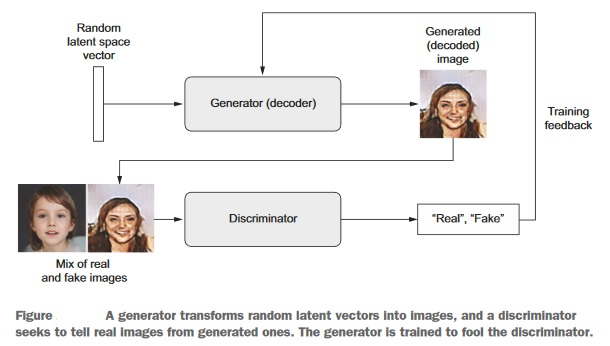

Remarkably, a <font color='blue'>GAN</font> is a system where the <font color='blue'>optimization minimum isn't fixed</font>, unlike in any other training setup you've encountered in this book. Normally, <font color='blue'>gradient descent</font> consists  of  <font color='blue'>rolling  down  hills</font>  in  a  static  loss  landscape.  But  with  a  GAN,  <font color='blue'>every  step</font> taken down the hill <font color='blue'>changes the entire landscape</font> a little. It's a dynamic system where the <font color='blue'>optimization process</font> is seeking not a minimum, but an <font color='blue'>equilibrium between two forces</font>. For this reason, GANs are notoriously difficult to train—getting a GAN to work requires lots of careful tuning of the model architecture and training parameters.

### A schematic GAN implementation

In  this  section,  we'll  explain  how  to  implement  a  GAN  in  Keras  in  its  barest  form. GANs  are  advanced,  so  diving  deeply  into  the  technical  details  of  architectures  like that of the <font color='blue'>StyleGAN2</font> that generated the images in the Figure below would be out of scope for  this  book.  The  specific  implementation  we'll  use  in  this  demonstration  is  a  <font color='blue'>deep convolutional GAN (DCGAN)</font>: a very basic GAN where the generator and discriminator are deep convnets.

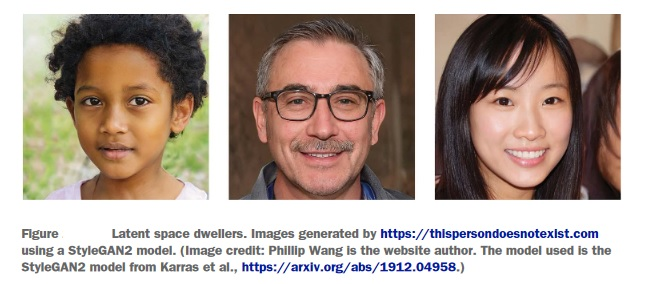

We'll  <font color='blue'>train</font>  our  GAN  on  <font color='blue'>images</font>  from  the  <font color='blue'>Large-scale  CelebFaces  Attributes  dataset</font> (known  as  CelebA),  a  dataset  of  200,000  faces  of  celebrities  (http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). To speed up training, we'll resize the images to 64 × 64,
so we'll be learning to generate 64 × 64 images of human faces.

Schematically, the GAN looks like this:

* A <font color='blue'>generator network</font> maps vectors of shape (`latent_dim,`) to images of shape `(64, 64, 3)`.
* A <font color='blue'>discriminator network</font> maps images of shape `(64, 64, 3)` to a <font color='blue'>binary score</font> estimating the probability that the image is real.
* A <font color='blue'>GAN</font> network <font color='blue'>chains</font> the generator and the  discriminator  <font color='blue'>together</font>:  `gan(x)  = discriminator(generator(x))`. Thus, this GAN network <font color='blue'>maps latent space vectors</font>  to  the  <font color='blue'>discriminator's  assessment</font>  of  the  <font color='blue'>realism</font>  of  these  latent  vectors  as decoded by the generator.
* We train the discriminator using examples of <font color='blue'>real and fake images</font> along with “real”/“fake” labels, just as we train any regular image-classification model.
* To  train  the  generator,  we  use  the  <font color='blue'>gradients  of  the  generator's  weights</font>  with regard to the loss of the GAN model. This means that at every step, we <font color='blue'>move</font> the weights of the generator in a direction that makes the <font color='blue'>discriminator more likely to  classify  as  “real”</font>  the  images  decoded  by  the  generator.  In  other  words,  we train the generator to <font color='blue'>fool</font> the discriminator.

### A bag of tricks

The process of <font color='blue'>training GANs</font> and tuning GAN implementations is notoriously <font color='blue'>difficult</font>. There are a number of known tricks you should keep in mind. Like most things in deep learning, it's more alchemy than science: these tricks are <font color='blue'>heuristics</font>, not theory-backed guidelines. They're supported by a level of intuitive understanding of the phenomenon at hand, and they're known to work well empirically, although not necessarily in every context.

Here are a few of the tricks used in the implementation of the GAN generator and discriminator in this section. It isn't an exhaustive list of GAN-related tips; you'll find many more across the GAN literature:

* We  use  <font color='blue'>strides</font>  instead  of  pooling  for  downsampling  feature  maps  in  the  discriminator, just like we did in our VAE encoder.
* We sample points from the latent space using a <font color='blue'>normal distribution</font> (Gaussian distribution), not a uniform distribution.
* Stochasticity is good for inducing robustness. Because GAN training results in a dynamic equilibrium, <font color='blue'>GANs</font> are likely to <font color='blue'>get stuck</font> in all sorts of ways. Introducing <font color='blue'>randomness</font> during training helps <font color='blue'>prevent this</font>. We introduce randomness by adding random noise to the labels for the discriminator.
* <font color='blue'>Sparse gradients</font> can <font color='blue'>hinder GAN training</font>. In deep learning, sparsity is often a desirable property, but not in GANs. Two things can induce gradient sparsity:  max  pooling  operations  and  relu  activations.  Instead  of  max  pooling, we recommend using <font color='blue'>strided convolutions for downsampling</font>, and we recommend  using  a  `LeakyReLU`  layer  instead  of  a  `relu`  activation.  It's  similar  to `relu`,  but  it relaxes sparsity constraints  by allowing small negative activation values.
* In  <font color='blue'>generated  images</font>,  it's  common  to  see  <font color='blue'>checkerboard  artifacts</font>  caused  by unequal  coverage  of  the  pixel  space  in  the  generator  (see  figure  below).  To  fix this,  we  use  a  kernel  size  that's  divisible  by  the  stride  size  whenever  we  use  a strided `Conv2DTranspose` or `Conv2D` in both the generator and the discriminator.

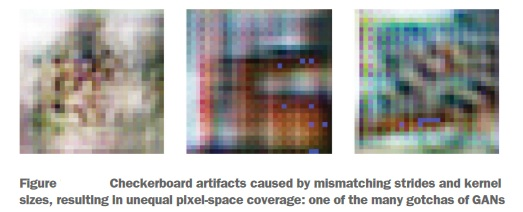

### Getting our hands on the CelebA dataset

You can download the dataset manually from the website: http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html. If you're using Colab, you can run the following to download the data from Google Drive and uncompress it.

**Getting the CelebA data**

In [ ]:
!mkdir celeba_gan                                                               # Create a working directory
!gdown 1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684 -O celeba_gan/data.zip                 # Download the compressed data using gdown (available by default in Colab; install it otherwise).
!unzip -qq celeba_gan/data.zip -d celeba_gan                                    # Uncompress the data

mkdir: cannot create directory ‘celeba_gan’: File exists
Downloading...
From: https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684
To: /content/celeba_gan/data.zip
100% 1.44G/1.44G [00:21<00:00, 66.8MB/s]


Once you've got the uncompressed images in a directory, you can use
`image_dataset_from_directory`  to  turn  it  into  a  dataset.  Since  we  <font color='blue'>just  need  the images</font>—there are no labels—we'll specify `label_mode=None`.

**Creating a dataset from a directory of images**

In [ ]:
from tensorflow import keras
dataset = keras.utils.image_dataset_from_directory(
    "celeba_gan",
    label_mode=None,                                                            # Only the images will be returned—no labels.
    image_size=(64, 64),
    batch_size=32,
    smart_resize=True)                                                          # We will resize the images to 64 × 64 by using a smart combination of cropping and resizing
                                                                                # to preserve aspect ratio. We don’t want face proportions to get distorted.

Found 202599 files belonging to 1 classes.


Finally, let's <font color='blue'>rescale</font> the images to the `[0-1]` range.

**Rescaling the images**

In [ ]:
dataset = dataset.map(lambda x: x / 255.)

You can use the following code to <font color='blue'>display</font> a <font color='blue'>sample image</font>.

**Displaying the first image**

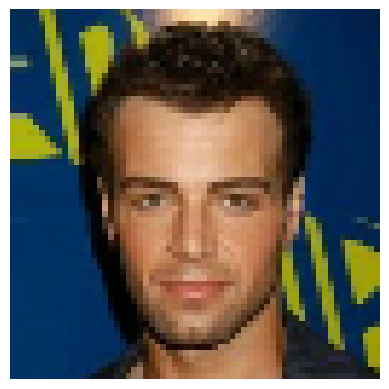

In [ ]:
import matplotlib.pyplot as plt
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

Here's an image of another celebrity.

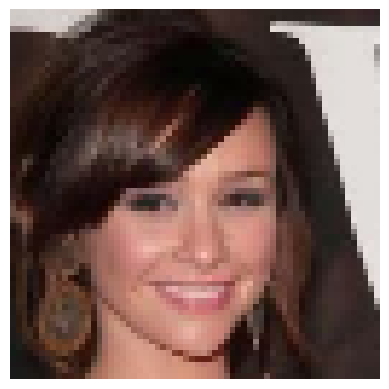

In [ ]:
import matplotlib.pyplot as plt
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[21])
    break

### The discriminator

First,  we'll  develop  a  discriminator  model  that  takes  as  <font color='blue'>input</font>  a  <font color='blue'>candidate  image</font> (real or synthetic) and classifies it into one of two classes: <font color='blue'>“generated image”</font> or <font color='blue'>“real image  that  comes  from  the  training  set.”</font>  One  of  the  many  issues  that  commonly arise with GANs is that the generator <font color='blue'>gets stuck</font> with generated images that look like noise.  A  possible  solution  is  to  use  <font color='blue'>dropout</font>  in  the  <font color='blue'>discriminator</font>,  so  that's  what  we will do here.

**The GAN discriminator network**

In [ ]:
from tensorflow.keras import layers

discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),                                                    # We add a single dropout layer: an important trick!
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

Here's the discriminator model summary:

In [ ]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

### The generator

Next,  let's  develop  a  <font color='blue'>generator</font>  model  that  turns  a  <font color='blue'>vector</font> (from  the  latent  space—during training it will be sampled at random) <font color='blue'>into</font> a <font color='blue'>candidate image</font>.

**GAN generator network**

In [ ]:
latent_dim = 128                                                                # The latent space will be made of 128-dimensional vectors.

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),                                              # Produce the same number  of coefficients we had at the level of the Flatten layer in the encoder.
        layers.Reshape((8, 8, 128)),                                            # Revert the Flatten layer of the encoder.
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),  # Revert the Conv2D layers of the encoder.
        layers.LeakyReLU(alpha=0.2),                                            # We use LeakyReLU as our activation.
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),  # The output ends up with shape (28, 28, 1)
    ],
    name="generator",
)

This is the generator model summary:

In [ ]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       262272    
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 256)       524544    
 Transpose)                                                      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

### The adversarial network

Finally,  we'll  set  up  the  GAN,  which  <font color='blue'>chains</font>  the  <font color='blue'>generator</font>  and  the  <font color='blue'>discriminator</font>. When  trained,  this  model  will  move  the  generator  in  a  direction  that  improves  its ability to <font color='blue'>fool</font> the discriminator. This model turns <font color='blue'>latent-space points</font> into a <font color='blue'>classification</font> decision—<font color='blue'>“fake”</font> or <font color='blue'>“real”</font>—and it's meant to be trained with labels that are always “these are real images.” So <font color='blue'>training GAN</font> will update the <font color='blue'>weights of generator</font> in  a  way  that  makes  discriminator  more  likely  to  predict  “real”  when  looking  at fake images.

To recapitulate,  this  is  what  the  training  loop  looks  like  schematically. For each epoch, you do the following:

1. Draw <font color='blue'>random points</font> in the latent space (random noise).
2. <font color='blue'>Generate images</font> with generator using this random noise.
3. <font color='blue'>Mix</font> the generated images with real ones.
4. <font color='blue'>Train  discriminator</font>  using  these  mixed  images,  with  corresponding  targets: either “real” (for the real images) or “fake” (for the generated images).
5. Draw <font color='blue'>new random points</font> in the latent space.
6. <font color='blue'>Train generator</font> using these <font color='blue'>random vectors</font>, with targets that all say “these are real  images.”  This  <font color='blue'>updates</font>  the  <font color='blue'>weights</font>  of  the  <font color='blue'>generator</font>  to  move  them  toward getting  the  discriminator  to  predict  “these  are  real  images”  for  generated images: this trains the generator to fool the discriminator.

Let's implement it. Like in our VAE example, we'll use a <font color='blue'>Model subclass</font> with a custom `train_step()`.  Note  that  we'll  use  <font color='blue'>two  optimizers</font>  (one  for  the  generator  and one  for  the  discriminator),  so  we  will  also  override  `compile()`  to  allow  for  passing two optimizers.



**The GAN `Model`**

In [ ]:
import tensorflow as tf
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")                  # Sets up metrics to track the two losses over each training epoch
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]                         # Return metrics for two losses

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(                               # Samples random points in the latent space
            shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)                # Decodes them to fake images
        combined_images = tf.concat([generated_images, real_images], axis=0)    # Combines them with real images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],              # Assembles labels, discriminating real from fake images
            axis=0
        )
        labels += 0.05 * tf.random.uniform(tf.shape(labels))                    # Adds random noise to the labels—an important trick!

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)                          # Trains the discriminator
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(                               # Samples random points in the latent space
            shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))                           # Assembles labels that say “these are all real images” (it’s a lie!)

        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)               # Trains the generator
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

Before we start training, let's also set up a <font color='blue'>callback</font> to <font color='blue'>monitor our results</font>: it will use the generator to create and save a number of fake images at the end of each epoch.

**A callback that samples generated images during training**

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")

Finally, we can start training.

**Compiling and training the GAN**

In [ ]:
epochs = 100                                                                    # You’ll start getting interesting results after epoch 20.

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/100
3234/6332 [==============>...............] - ETA: 13:08 - d_loss: 0.5894 - g_loss: 1.2342

When training, you may <font color='blue'>see</font> the <font color='blue'>adversarial loss</font> begin to <font color='blue'>increase considerably</font>, while the discriminative loss tends to zero—the discriminator may end up dominating the generator. If that's the case, try <font color='blue'>reducing the discriminator learning rate</font>, and increase the dropout rate of the discriminator.

The Figure below shows what our GAN is capable of generating after 30 epochs of training.

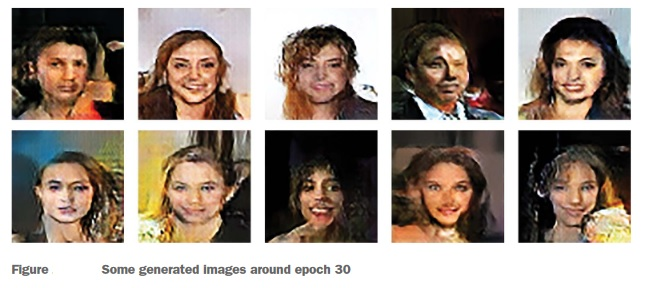

### Wrapping up

* A <font color='blue'>GAN</font> consists of a <font color='blue'>generator</font> network coupled with a <font color='blue'>discriminator</font> network.
The <font color='blue'>discriminator</font> is trained to <font color='blue'>differentiate</font> between the <font color='blue'>output</font> of the generator and real images from a training dataset, and the <font color='blue'>generator</font> is trained to <font color='blue'>fool the discriminator</font>. Remarkably, the generator never sees images from the training set directly; the information it has about the data comes from the discriminator.
* GANs are <font color='blue'>difficult to train</font>, because training a GAN is a dynamic process rather than  a  simple  gradient  descent  process  with  a  fixed  loss  landscape.  Getting a GAN  to  train  correctly  requires  using  a  number  of  <font color='blue'>heuristic  tricks</font>,  as  well  as extensive tuning.
* GANs  can  potentially  produce  <font color='blue'>highly  realistic  images</font>.  But  unlike  VAEs,  the <font color='blue'>latent space</font> they learn doesn't have a <font color='blue'>neat continuous structure</font> and thus may not be suited for certain practical applications, such as image editing via latent-space concept vectors.

These few techniques cover only the basics of this fast-expanding field. There's a lot more to discover out there—generative deep learning is deserving of an entire book of its own.

## Summary

* You can use a <font color='blue'>sequence-to-sequence model</font> to generate <font color='blue'>sequence data</font>, one step at a  time. This  is <font color='blue'>applicable</font> to <font color='blue'>text generation</font>, but  also  to  note-by-note music generation or any other type of timeseries data.
* <font color='blue'>DeepDream</font>  works  by  <font color='blue'>maximizing</font>  convnet  layer  activations  through <font color='blue'>gradient ascent</font> in input space.
* In the <font color='blue'>style-transfer algorithm</font>, a <font color='blue'>content</font> image and a <font color='blue'>style</font> image are <font color='blue'>combined</font> together via <font color='blue'>gradient descent</font> to produce an image with the high-level features of the content image and the local characteristics of the style image.
* <font color='blue'>VAEs</font>  and  <font color='blue'>GANs</font>  are  models  that  learn  a  <font color='blue'>latent  space  of  images</font>  and  can  then <font color='blue'>dream up entirely new images</font> by sampling from the latent space. <font color='blue'>Concept vectors</font> in the latent space can even be used for <font color='blue'>image editing</font>.